In [3]:
import os

modified_config = "/RnD/horse/animalpose_center.py"
# base_config = "/mmpose/mmpose/.mim/configs/_base_/datasets/animalpose.py"
base_config = "/RnD/mmpose/configs/_base_/datasets/animalpose.py"
# base_config = "/opt/conda/lib/python3.8/site-packages/mmpose/.mim/configs/_base_/datasets/animalpose.py"
data = modified_config+" "+base_config
cmd = f"""cp {data}"""
print(cmd)
os.system(cmd)

cp /RnD/horse/animalpose_center.py /RnD/mmpose/configs/_base_/datasets/animalpose.py


0

In [4]:
# Check Pytorch installation
import torch, torchvision

print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose

print('mmpose version:', mmpose.__version__)
import mmcv
print('mmcv version:', mmcv.__version__)
import mmengine, mmdet
print('mmengine version:', mmengine.__version__)
print('mmdet version:', mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

torch version: 2.0.1+cu118 True
torchvision version: 0.15.2+cu118
mmpose version: 1.3.2
mmcv version: 2.0.1
mmengine version: 0.10.4
mmdet version: 3.0.0


In [5]:
#config파일 불러옴 
#base를 
from mmengine.config import Config
from mmengine.runner import Runner

CUDA_VISIBLE_DEVICES="1"
torch.cuda.set_device(1)

config_path="/RnD/horse/rtmpose_s_8xb256_420e_aic_coco_256x192.py"
cfg = Config.fromfile(config_path)

num_keypoints = 34
input_size = (384, 288)  # 입력 크기
train_batch = 32  # 배치 크기
val_batch = 24
num_epochs = 600
val_interval_num = 10
base_lr = 1e-3  # 학습률
stage2_num_epochs = 30
worker = 16  # 워커 수

save_path = '/RnD/horse/Test/'
data_root='/RnD/horse/'

In [6]:
cfg['default_scope'] = 'mmpose'
cfg['default_hooks'] = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=50),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(
        type='CheckpointHook',
        interval=10,
        save_best='coco/AP',
        rule='greater'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    visualization=dict(type='PoseVisualizationHook', enable=False))

cfg['env_cfg'] = dict(
    cudnn_benchmark=False,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
cfg['vis_backends'] = [dict(type='LocalVisBackend')]
cfg['visualizer'] = dict(
    type='PoseLocalVisualizer',
    vis_backends=[dict(type='LocalVisBackend')],
    name='visualizer')
cfg['log_processor'] = dict(
    type='LogProcessor', window_size=50, by_epoch=True, num_digits=6)
cfg['log_level'] = 'INFO'
cfg['load_from'] = None
cfg['resume'] = False
cfg['backend_args'] = dict(backend='local')
cfg['train_cfg'] = dict(by_epoch=True, max_epochs=num_epochs, val_interval=val_interval_num)
cfg['val_cfg'] = dict()
cfg['test_cfg'] = dict()
cfg['optim_wrapper'] = dict(
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    clip_grad=dict(max_norm=35, norm_type=2),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))
cfg['param_scheduler'] = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=1000),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=num_epochs // 2,
        end=num_epochs,
        T_max=num_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

cfg['auto_scale_lr'] = dict(base_batch_size=1024)
cfg['codec'] = dict(
    type='SimCCLabel',
    input_size=input_size,
    sigma=(4.9, 5.66),
    simcc_split_ratio=2.0,
    normalize=False,
    use_dark=False)
cfg['model'] = dict(
    type='TopdownPoseEstimator',
    data_preprocessor=dict(
        type='PoseDataPreprocessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True),
    backbone=dict(
        _scope_='mmdet',
        type='CSPNeXt',
        arch='P5',
        expand_ratio=0.5,
        deepen_factor=1.,
        widen_factor=1.,
        out_indices=(4, ),
        channel_attention=True,
        norm_cfg=dict(type='SyncBN'),
        act_cfg=dict(type='SiLU'),
        init_cfg=dict(
            type='Pretrained',
            prefix='backbone.',
            checkpoint='https://download.openmmlab.com/mmpose/v1/projects/'
            'rtmposev1/cspnext-l_udp-aic-coco_210e-256x192-273b7631_20230130.pth'  # noqa
        )),
    head=dict(
        type='RTMCCHead',
        in_channels=1024,
        out_channels=num_keypoints,
        input_size=cfg['codec']['input_size'],
        in_featuremap_size=tuple([s // 32 for s in cfg['codec']['input_size']]),
        simcc_split_ratio=cfg['codec']['simcc_split_ratio'],
        final_layer_kernel_size=7,
        gau_cfg=dict(
            hidden_dims=256,
            s=128,
            expansion_factor=2,
            dropout_rate=0.,
            drop_path=0.,
            act_fn='SiLU',
            use_rel_bias=False,
            pos_enc=False),
        loss=dict(
            type='KLDiscretLoss',
            use_target_weight=True,
            beta=10.,
            label_softmax=True),
        decoder=cfg['codec']),
    test_cfg=dict(flip_test=True))


cfg['dataset_type'] = 'AnimalPoseDataset'
cfg['data_mode'] = 'topdown'
cfg['data_root'] = data_root

cfg['train_pipeline'] = [
    dict(type='LoadImage', backend_args=cfg['backend_args']),
    dict(type='GetBBoxCenterScale'),
    dict(type='RandomFlip', direction='horizontal'),
    dict(type='RandomHalfBody'),
    dict(
        type='RandomBBoxTransform', scale_factor=[0.6, 1.4], rotate_factor=80),
    dict(type='TopdownAffine', input_size=cfg['codec']['input_size']),
    dict(type='mmdet.YOLOXHSVRandomAug'),
    dict(
        type='Albumentation',
        transforms=[
            dict(type='Blur', p=0.1),
            dict(type='MedianBlur', p=0.1),
            dict(
                type='CoarseDropout',
                max_holes=1,
                max_height=0.4,
                max_width=0.4,
                min_holes=1,
                min_height=0.2,
                min_width=0.2,
                p=1.),
        ]),
    dict(type='GenerateTarget', encoder=cfg['codec']),
    dict(type='PackPoseInputs')
]

cfg['val_pipeline'] = [
    dict(type='LoadImage', backend_args=cfg['backend_args']),
    dict(type='GetBBoxCenterScale'),
    dict(type='TopdownAffine', input_size=cfg['codec']['input_size']),
    dict(type='PackPoseInputs')
]

cfg['train_pipeline_stage2'] = [
    dict(type='LoadImage', backend_args=cfg['backend_args']),
    dict(type='GetBBoxCenterScale'),
    dict(type='RandomFlip', direction='horizontal'),
    dict(type='RandomHalfBody'),
    dict(
        type='RandomBBoxTransform',
        shift_factor=0.,
        scale_factor=[0.75, 1.25],
        rotate_factor=60),
    dict(type='TopdownAffine', input_size=cfg['codec']['input_size']),
    dict(type='mmdet.YOLOXHSVRandomAug'),
    dict(
        type='Albumentation',
        transforms=[
            dict(type='Blur', p=0.1),
            dict(type='MedianBlur', p=0.1),
            dict(
                type='CoarseDropout',
                max_holes=1,
                max_height=0.4,
                max_width=0.4,
                min_holes=1,
                min_height=0.2,
                min_width=0.2,
                p=0.5),
        ]),
    dict(type='GenerateTarget', encoder=cfg['codec']),
    dict(type='PackPoseInputs')
]
cfg['test_pipeline']=cfg['val_pipeline']

cfg['train_dataloader'] = dict(
    batch_size=train_batch,
    num_workers=worker,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dict(
        type='AnimalPoseDataset',
        data_root='',
        data_mode='topdown',
        ann_file='/RnD/horse/horse_trains.json',
        data_prefix=dict(img=''),
        pipeline=cfg['train_pipeline'],
    ))

cfg['val_dataloader'] = dict(
    batch_size=val_batch,
    num_workers=worker,
    persistent_workers=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False, round_up=False),
    dataset=dict(
        type='AnimalPoseDataset',
        data_root='',
        data_mode='topdown',
        ann_file='/RnD/horse/horse_vals.json',
        data_prefix=dict(img=''),
        test_mode=True,
        pipeline=cfg['val_pipeline'],
    ))
cfg['test_dataloader'] = dict(
    batch_size=val_batch,
    num_workers=worker,
    persistent_workers=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False, round_up=False),
    dataset=dict(
        type='AnimalPoseDataset',
        data_root='',
        data_mode='topdown',
        ann_file='/RnD/horse/horse_vals.json',
        data_prefix=dict(img=''),
        test_mode=True,
        pipeline=cfg['test_pipeline'],
    ))
cfg['test_dataloader'] = cfg['val_dataloader']

cfg['val_evaluator'] = dict(
    type='CocoMetric',
    ann_file='/RnD/horse/horse_vals.json')
cfg['test_evaluator'] = dict(
    type='CocoMetric',
    ann_file='/RnD/horse/horse_vals.json')
cfg['custom_hooks'] = [
    dict(
        type='EMAHook',
        ema_type='ExpMomentumEMA',
        momentum=0.0002,
        update_buffers=True,
        priority=49),
    dict(
        type='mmdet.PipelineSwitchHook',
        switch_epoch=num_epochs - stage2_num_epochs,
        switch_pipeline=cfg['train_pipeline_stage2'])
]
cfg['work_dir'] = save_path
cfg['launcher'] = 'none'

In [7]:
torch.cuda.set_device(1)

In [8]:
runner = Runner.from_cfg(cfg)
runner.train()

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.19 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


10/24 08:59:03 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 21
    GPU 0,1: NVIDIA GeForce RTX 4070 SUPER
    CUDA_HOME: None
    GCC: gcc (Ubuntu 12.3.0-1ubuntu1~22.04) 12.3.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=s

/RnD/mmpose/mmpose/datasets/datasets/utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/animalpose.py" does not exist. A matched config file "/RnD/mmpose/mmpose/.mim/configs/_base_/datasets/animalpose.py" will be used instead.
  warnings.warn(
/RnD/mmpose/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: Blur is not pixel-level transformations. Please use with caution.
  warnings.warn(
/RnD/mmpose/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: MedianBlur is not pixel-level transformations. Please use with caution.
  warnings.warn(
/RnD/mmpose/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: CoarseDropout is not pixel-level transformations. Please use with caution.
  warnings.warn(


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stem.0.bn.weight:weight_decay=0.0
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stem.0.bn.bias:weight_decay=0.0
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stem.1.bn.weight:weight_decay=0.0
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stem.1.bn.bias:weight_decay=0.0
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stem.2.bn.weight:weight_decay=0.0
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stem.2.bn.bias:weight_decay=0.0
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stage1.0.bn.weight:weight_decay=0.0
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stage1.0.bn.bias:weight_decay=0.0
10/24 08:59:05 - mmengine - INFO - paramwise_options -- backbone.stage1.1.main_conv.bn.weight:weight_decay=0.0
10/24 08:59:05 - m

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


10/24 08:59:17 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 08:59:17 - mmengine - INFO - Epoch(train)   [1][39/39]  base_lr: 3.804766e-05 lr: 3.804766e-05  eta: 1:48:51  time: 0.279605  data_time: 0.047556  memory: 7997  grad_norm: 0.137128  loss: 0.394961  loss_kpt: 0.394961  acc_pose: 0.024510


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 08:59:27 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 08:59:27 - mmengine - INFO - Epoch(train)   [2][39/39]  base_lr: 7.708631e-05 lr: 7.708631e-05  eta: 1:43:57  time: 0.247994  data_time: 0.030139  memory: 7997  grad_norm: 0.212785  loss: 0.355221  loss_kpt: 0.355221  acc_pose: 0.137255


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 08:59:36 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 08:59:36 - mmengine - INFO - Epoch(train)   [3][39/39]  base_lr: 1.161250e-04 lr: 1.161250e-04  eta: 1:42:12  time: 0.246359  data_time: 0.029358  memory: 7997  grad_norm: 0.335848  loss: 0.311117  loss_kpt: 0.311117  acc_pose: 0.257353


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 08:59:47 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 08:59:47 - mmengine - INFO - Epoch(train)   [4][39/39]  base_lr: 1.551636e-04 lr: 1.551636e-04  eta: 1:41:28  time: 0.248438  data_time: 0.032027  memory: 7997  grad_norm: 0.400960  loss: 0.260593  loss_kpt: 0.260593  acc_pose: 0.605392


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 08:59:57 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 08:59:57 - mmengine - INFO - Epoch(train)   [5][39/39]  base_lr: 1.942023e-04 lr: 1.942023e-04  eta: 1:40:49  time: 0.247374  data_time: 0.030646  memory: 7997  grad_norm: 0.404431  loss: 0.222740  loss_kpt: 0.222740  acc_pose: 0.696078
10/24 09:00:07 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:00:07 - mmengine - INFO - Epoch(train)   [6][39/39]  base_lr: 2.332409e-04 lr: 2.332409e-04  eta: 1:40:23  time: 0.247823  data_time: 0.032501  memory: 7997  grad_norm: 0.367611  loss: 0.202889  loss_kpt: 0.202889  acc_pose: 0.808824


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:00:16 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:00:16 - mmengine - INFO - Epoch(train)   [7][39/39]  base_lr: 2.722795e-04 lr: 2.722795e-04  eta: 1:39:53  time: 0.247231  data_time: 0.030984  memory: 7997  grad_norm: 0.342656  loss: 0.190061  loss_kpt: 0.190061  acc_pose: 0.747549
10/24 09:00:26 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:00:26 - mmengine - INFO - Epoch(train)   [8][39/39]  base_lr: 3.113182e-04 lr: 3.113182e-04  eta: 1:39:30  time: 0.246128  data_time: 0.029741  memory: 7997  grad_norm: 0.308076  loss: 0.180557  loss_kpt: 0.180557  acc_pose: 0.830882


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:00:36 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:00:36 - mmengine - INFO - Epoch(train)   [9][39/39]  base_lr: 3.503568e-04 lr: 3.503568e-04  eta: 1:39:17  time: 0.248362  data_time: 0.031327  memory: 7997  grad_norm: 0.296195  loss: 0.173907  loss_kpt: 0.173907  acc_pose: 0.838235


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:00:46 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:00:46 - mmengine - INFO - Epoch(train)  [10][39/39]  base_lr: 3.893955e-04 lr: 3.893955e-04  eta: 1:38:59  time: 0.246591  data_time: 0.029821  memory: 7997  grad_norm: 0.279700  loss: 0.168726  loss_kpt: 0.168726  acc_pose: 0.919118
10/24 09:00:46 - mmengine - INFO - Saving checkpoint at 10 epochs
10/24 09:00:52 - mmengine - INFO - Evaluating CocoMetric...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.945
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ]

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:01:05 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:01:05 - mmengine - INFO - Epoch(train)  [11][39/39]  base_lr: 4.284341e-04 lr: 4.284341e-04  eta: 1:38:43  time: 0.246691  data_time: 0.030086  memory: 7997  grad_norm: 0.269941  loss: 0.166024  loss_kpt: 0.166024  acc_pose: 0.892157


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:01:15 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:01:15 - mmengine - INFO - Epoch(train)  [12][39/39]  base_lr: 4.674728e-04 lr: 4.674728e-04  eta: 1:38:29  time: 0.246901  data_time: 0.030691  memory: 7997  grad_norm: 0.254721  loss: 0.161848  loss_kpt: 0.161848  acc_pose: 0.948529
10/24 09:01:25 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:01:25 - mmengine - INFO - Epoch(train)  [13][39/39]  base_lr: 5.065114e-04 lr: 5.065114e-04  eta: 1:38:21  time: 0.249615  data_time: 0.033011  memory: 7997  grad_norm: 0.246801  loss: 0.158329  loss_kpt: 0.158329  acc_pose: 0.941176
10/24 09:01:35 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:01:35 - mmengine - INFO - Epoch(train)  [14][39/39]  base_lr: 5.455501e-04 lr: 5.455501e-04  eta: 1:38:06  time: 0.245845  data_time: 0.029437  memory: 7997  grad_norm: 0.224157  loss: 0.154492  loss_kpt: 

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:03:54 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:03:54 - mmengine - INFO - Epoch(train)  [27][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:35:48  time: 0.247182  data_time: 0.031218  memory: 7997  grad_norm: 0.150868  loss: 0.131223  loss_kpt: 0.131223  acc_pose: 0.909314
10/24 09:04:04 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:04:04 - mmengine - INFO - Epoch(train)  [28][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:35:39  time: 0.248444  data_time: 0.032308  memory: 7997  grad_norm: 0.152265  loss: 0.130671  loss_kpt: 0.130671  acc_pose: 0.786765
10/24 09:04:14 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:04:14 - mmengine - INFO - Epoch(train)  [29][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:35:26  time: 0.245136  data_time: 0.029146  memory: 7997  grad_norm: 0.150025  loss: 0.127498  loss_kpt: 

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:04:42 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:04:42 - mmengine - INFO - Epoch(train)  [31][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:35:03  time: 0.246480  data_time: 0.030369  memory: 7997  grad_norm: 0.132769  loss: 0.123058  loss_kpt: 0.123058  acc_pose: 0.968137
10/24 09:04:52 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:04:52 - mmengine - INFO - Epoch(train)  [32][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:34:51  time: 0.245060  data_time: 0.028669  memory: 7997  grad_norm: 0.128246  loss: 0.121641  loss_kpt: 0.121641  acc_pose: 0.970588
10/24 09:05:02 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:05:02 - mmengine - INFO - Epoch(train)  [33][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:34:41  time: 0.247644  data_time: 0.029580  memory: 7997  grad_norm: 0.140481  loss: 0.122193  loss_kpt: 

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:06:12 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:06:12 - mmengine - INFO - Epoch(train)  [40][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:33:26  time: 0.246903  data_time: 0.029487  memory: 7997  grad_norm: 0.122377  loss: 0.114736  loss_kpt: 0.114736  acc_pose: 0.916667
10/24 09:06:12 - mmengine - INFO - Saving checkpoint at 40 epochs
10/24 09:06:17 - mmengine - INFO - Evaluating CocoMetric...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.982
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ]

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:06:27 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:06:27 - mmengine - INFO - Epoch(train)  [41][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:33:16  time: 0.247769  data_time: 0.032143  memory: 7997  grad_norm: 0.120866  loss: 0.115165  loss_kpt: 0.115165  acc_pose: 0.992647
10/24 09:06:37 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:06:37 - mmengine - INFO - Epoch(train)  [42][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:33:04  time: 0.244805  data_time: 0.028425  memory: 7997  grad_norm: 0.118421  loss: 0.111606  loss_kpt: 0.111606  acc_pose: 0.992647
10/24 09:06:47 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:06:47 - mmengine - INFO - Epoch(train)  [43][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:32:55  time: 0.248233  data_time: 0.031372  memory: 7997  grad_norm: 0.115273  loss: 0.112126  loss_kpt: 

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:07:37 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:07:37 - mmengine - INFO - Epoch(train)  [48][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:32:03  time: 0.245843  data_time: 0.028562  memory: 7997  grad_norm: 0.109299  loss: 0.107253  loss_kpt: 0.107253  acc_pose: 1.000000
10/24 09:07:47 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:07:47 - mmengine - INFO - Epoch(train)  [49][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:31:53  time: 0.246932  data_time: 0.031017  memory: 7997  grad_norm: 0.098416  loss: 0.105596  loss_kpt: 0.105596  acc_pose: 0.960784
10/24 09:07:57 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:07:57 - mmengine - INFO - Epoch(train)  [50][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:31:43  time: 0.247366  data_time: 0.028528  memory: 7997  grad_norm: 0.100698  loss: 0.105596  loss_kpt: 

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 09:13:33 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:13:33 - mmengine - INFO - Epoch(train)  [81][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:26:25  time: 0.247322  data_time: 0.029798  memory: 7997  grad_norm: 0.085223  loss: 0.096660  loss_kpt: 0.096660  acc_pose: 0.968137
10/24 09:13:43 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:13:43 - mmengine - INFO - Epoch(train)  [82][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:26:15  time: 0.246673  data_time: 0.029772  memory: 7997  grad_norm: 0.083223  loss: 0.095123  loss_kpt: 0.095123  acc_pose: 1.000000
10/24 09:13:53 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 09:13:53 - mmengine - INFO - Epoch(train)  [83][39/39]  base_lr: 1.000000e-03 lr: 1.000000e-03  eta: 1:26:06  time: 0.249316  data_time: 0.033764  memory: 7997  grad_norm: 0.101447  loss: 0.097085  loss_kpt: 

/RnD/mmpose/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: Blur is not pixel-level transformations. Please use with caution.
  warnings.warn(
/RnD/mmpose/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: MedianBlur is not pixel-level transformations. Please use with caution.
  warnings.warn(
/RnD/mmpose/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: CoarseDropout is not pixel-level transformations. Please use with caution.
  warnings.warn(
/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:39:05 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:39:05 - mmengine - INFO - Epoch(train) [571][39/39]  base_lr: 7.177400e-05 lr: 7.177400e-05  eta: 0:04:49  time: 0.262834  data_time: 0.045591  memory: 7997  grad_norm: 0.050338  loss: 0.030761  loss_kpt: 0.030761  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:39:16 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:39:16 - mmengine - INFO - Epoch(train) [572][39/39]  base_lr: 7.031012e-05 lr: 7.031012e-05  eta: 0:04:39  time: 0.251933  data_time: 0.031753  memory: 7997  grad_norm: 0.049557  loss: 0.029374  loss_kpt: 0.029374  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:39:26 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:39:26 - mmengine - INFO - Epoch(train) [573][39/39]  base_lr: 6.889610e-05 lr: 6.889610e-05  eta: 0:04:29  time: 0.247034  data_time: 0.030196  memory: 7997  grad_norm: 0.051029  loss: 0.029034  loss_kpt: 0.029034  acc_pose: 1.000000
10/24 10:39:36 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:39:36 - mmengine - INFO - Epoch(train) [574][39/39]  base_lr: 6.753210e-05 lr: 6.753210e-05  eta: 0:04:19  time: 0.249067  data_time: 0.031404  memory: 7997  grad_norm: 0.050012  loss: 0.028926  loss_kpt: 0.028926  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:39:46 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:39:46 - mmengine - INFO - Epoch(train) [575][39/39]  base_lr: 6.621826e-05 lr: 6.621826e-05  eta: 0:04:09  time: 0.248783  data_time: 0.032035  memory: 7997  grad_norm: 0.049803  loss: 0.028838  loss_kpt: 0.028838  acc_pose: 1.000000
10/24 10:39:56 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:39:56 - mmengine - INFO - Epoch(train) [576][39/39]  base_lr: 6.495473e-05 lr: 6.495473e-05  eta: 0:03:59  time: 0.246877  data_time: 0.029662  memory: 7997  grad_norm: 0.049643  loss: 0.028672  loss_kpt: 0.028672  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:40:06 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:40:06 - mmengine - INFO - Epoch(train) [577][39/39]  base_lr: 6.374166e-05 lr: 6.374166e-05  eta: 0:03:49  time: 0.248792  data_time: 0.032310  memory: 7997  grad_norm: 0.050445  loss: 0.028412  loss_kpt: 0.028412  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:40:16 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:40:16 - mmengine - INFO - Epoch(train) [578][39/39]  base_lr: 6.257916e-05 lr: 6.257916e-05  eta: 0:03:39  time: 0.248286  data_time: 0.030962  memory: 7997  grad_norm: 0.050228  loss: 0.028347  loss_kpt: 0.028347  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:40:26 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:40:26 - mmengine - INFO - Epoch(train) [579][39/39]  base_lr: 6.146738e-05 lr: 6.146738e-05  eta: 0:03:29  time: 0.247500  data_time: 0.031000  memory: 7997  grad_norm: 0.049969  loss: 0.028269  loss_kpt: 0.028269  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:40:36 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:40:36 - mmengine - INFO - Epoch(train) [580][39/39]  base_lr: 6.040642e-05 lr: 6.040642e-05  eta: 0:03:19  time: 0.249753  data_time: 0.032212  memory: 7997  grad_norm: 0.049836  loss: 0.028511  loss_kpt: 0.028511  acc_pose: 1.000000
10/24 10:40:36 - mmengine - INFO - Saving checkpoint at 580 epochs
10/24 10:40:39 - mmengine - INFO - Evaluating CocoMetric...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.987
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:40:49 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:40:49 - mmengine - INFO - Epoch(train) [581][39/39]  base_lr: 5.939642e-05 lr: 5.939642e-05  eta: 0:03:09  time: 0.247947  data_time: 0.031262  memory: 7997  grad_norm: 0.049937  loss: 0.028617  loss_kpt: 0.028617  acc_pose: 1.000000
10/24 10:40:59 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:40:59 - mmengine - INFO - Epoch(train) [582][39/39]  base_lr: 5.843747e-05 lr: 5.843747e-05  eta: 0:02:59  time: 0.247590  data_time: 0.030470  memory: 7997  grad_norm: 0.050833  loss: 0.028796  loss_kpt: 0.028796  acc_pose: 1.000000
10/24 10:41:09 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:41:09 - mmengine - INFO - Epoch(train) [583][39/39]  base_lr: 5.752969e-05 lr: 5.752969e-05  eta: 0:02:49  time: 0.250224  data_time: 0.031017  memory: 7997  grad_norm: 0.049503  loss: 0.028044  loss_kpt: 

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:41:19 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:41:19 - mmengine - INFO - Epoch(train) [584][39/39]  base_lr: 5.667317e-05 lr: 5.667317e-05  eta: 0:02:39  time: 0.247367  data_time: 0.031506  memory: 7997  grad_norm: 0.050257  loss: 0.028301  loss_kpt: 0.028301  acc_pose: 1.000000
10/24 10:41:29 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:41:29 - mmengine - INFO - Epoch(train) [585][39/39]  base_lr: 5.586801e-05 lr: 5.586801e-05  eta: 0:02:29  time: 0.248845  data_time: 0.032346  memory: 7997  grad_norm: 0.049704  loss: 0.028265  loss_kpt: 0.028265  acc_pose: 1.000000
10/24 10:41:39 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:41:39 - mmengine - INFO - Epoch(train) [586][39/39]  base_lr: 5.511429e-05 lr: 5.511429e-05  eta: 0:02:19  time: 0.248323  data_time: 0.031086  memory: 7997  grad_norm: 0.049693  loss: 0.027927  loss_kpt: 

/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:42:42 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:42:42 - mmengine - INFO - Epoch(train) [592][39/39]  base_lr: 5.167658e-05 lr: 5.167658e-05  eta: 0:01:19  time: 0.248503  data_time: 0.031512  memory: 7997  grad_norm: 0.049389  loss: 0.028194  loss_kpt: 0.028194  acc_pose: 1.000000
10/24 10:42:52 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:42:52 - mmengine - INFO - Epoch(train) [593][39/39]  base_lr: 5.128498e-05 lr: 5.128498e-05  eta: 0:01:09  time: 0.244952  data_time: 0.028535  memory: 7997  grad_norm: 0.049182  loss: 0.027814  loss_kpt: 0.027814  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:43:02 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:43:02 - mmengine - INFO - Epoch(train) [594][39/39]  base_lr: 5.094533e-05 lr: 5.094533e-05  eta: 0:00:59  time: 0.247429  data_time: 0.029170  memory: 7997  grad_norm: 0.050239  loss: 0.028478  loss_kpt: 0.028478  acc_pose: 1.000000
10/24 10:43:12 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:43:12 - mmengine - INFO - Epoch(train) [595][39/39]  base_lr: 5.065766e-05 lr: 5.065766e-05  eta: 0:00:49  time: 0.246475  data_time: 0.030215  memory: 7997  grad_norm: 0.051579  loss: 0.027817  loss_kpt: 0.027817  acc_pose: 0.992647


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:43:22 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:43:22 - mmengine - INFO - Epoch(train) [596][39/39]  base_lr: 5.042201e-05 lr: 5.042201e-05  eta: 0:00:39  time: 0.247661  data_time: 0.030156  memory: 7997  grad_norm: 0.051825  loss: 0.028036  loss_kpt: 0.028036  acc_pose: 1.000000


/RnD/mmpose/mmpose/codecs/simcc_label.py:211: RuntimeWarning: invalid value encountered in cast
  keypoints_split = keypoints_split.astype(np.int64)


10/24 10:43:32 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:43:32 - mmengine - INFO - Epoch(train) [597][39/39]  base_lr: 5.023841e-05 lr: 5.023841e-05  eta: 0:00:29  time: 0.251930  data_time: 0.034955  memory: 7997  grad_norm: 0.049449  loss: 0.027522  loss_kpt: 0.027522  acc_pose: 1.000000
10/24 10:43:42 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:43:42 - mmengine - INFO - Epoch(train) [598][39/39]  base_lr: 5.010686e-05 lr: 5.010686e-05  eta: 0:00:19  time: 0.246194  data_time: 0.029521  memory: 7997  grad_norm: 0.049994  loss: 0.027744  loss_kpt: 0.027744  acc_pose: 1.000000
10/24 10:43:52 - mmengine - INFO - Exp name: rtmpose_s_8xb256_420e_aic_coco_256x192_20241024_085902
10/24 10:43:52 - mmengine - INFO - Epoch(train) [599][39/39]  base_lr: 5.002740e-05 lr: 5.002740e-05  eta: 0:00:09  time: 0.249191  data_time: 0.032337  memory: 7997  grad_norm: 0.050719  loss: 0.028043  loss_kpt: 

TopdownPoseEstimator(
  (data_preprocessor): PoseDataPreprocessor()
  (backbone): CSPNeXt(
    (stem): Sequential(
      (0): ConvModule(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (1): ConvModule(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (2): ConvModule(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
    )
    (stage1): Sequential(
      (0): ConvModule(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), st

In [23]:
import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope
import numpy as np

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

local_runtime = False

try:
    from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
    local_runtime = True

#img = 'test/19912_TCENTER.png'
img = '/RnD/horse/2_1_2_del/image_359.jpg'
# TCENTER_025436_0000010000xxxxx_N_0
#img = '/RnD/mmpose+yolo_result/TCENTER_009972_011xxxxxxxxxxxx_N_0.png'
pose_config = 'Test/rtmpose-m_8xb256-420e_coco-256x192.py'
pose_checkpoint = 'Test/epoch_580.pth'
det_config = '/RnD/mmpose/demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

device = 'cuda:1'
cfg_options = dict(model=dict(test_cfg=dict(output_heatmaps=True)))


# build detector
detector = init_detector(
    det_config,
    det_checkpoint,
    device=device
)

# build pose estimator
pose_estimator = init_pose_estimator(
    pose_config,
    pose_checkpoint,
    device=device,
    cfg_options=cfg_options
)

# init visualizer
pose_estimator.cfg.visualizer.radius = 5
pose_estimator.cfg.visualizer.line_width = 10
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by local backend from path: Test/epoch_580.pth


In [24]:
def visualize_img(img_path, detector, pose_estimator, visualizer,
                  show_interval, out_file):
    """Visualize predicted keypoints (and heatmaps) of one image."""
    # predict bbox
    scope = detector.cfg.get('default_scope', 'mmdet')
    if scope is not None:
        init_default_scope(scope)
    detect_result = inference_detector(detector, img_path)
    pred_instance = detect_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate(
        (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    
    # 말 클래스(COCO dataset에서 17)만 필터링하도록 변경
    bboxes = bboxes[np.logical_and(pred_instance.labels == 17,  # horse class
                                   pred_instance.scores > 0.3)]
    bboxes = bboxes[nms(bboxes, 0.3)][:, :4]
    
    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img_path, bboxes)
    data_samples = merge_data_samples(pose_results)
    
    # show the results
    img = mmcv.imread(img_path, channel_order='rgb')
    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=show_interval,
        out_file=out_file,
        kpt_thr=0.3)

In [25]:
visualize_img(
    img,
    detector,
    pose_estimator,
    visualizer,
    show_interval=0,
    out_file=None)

vis_result = visualizer.get_image()

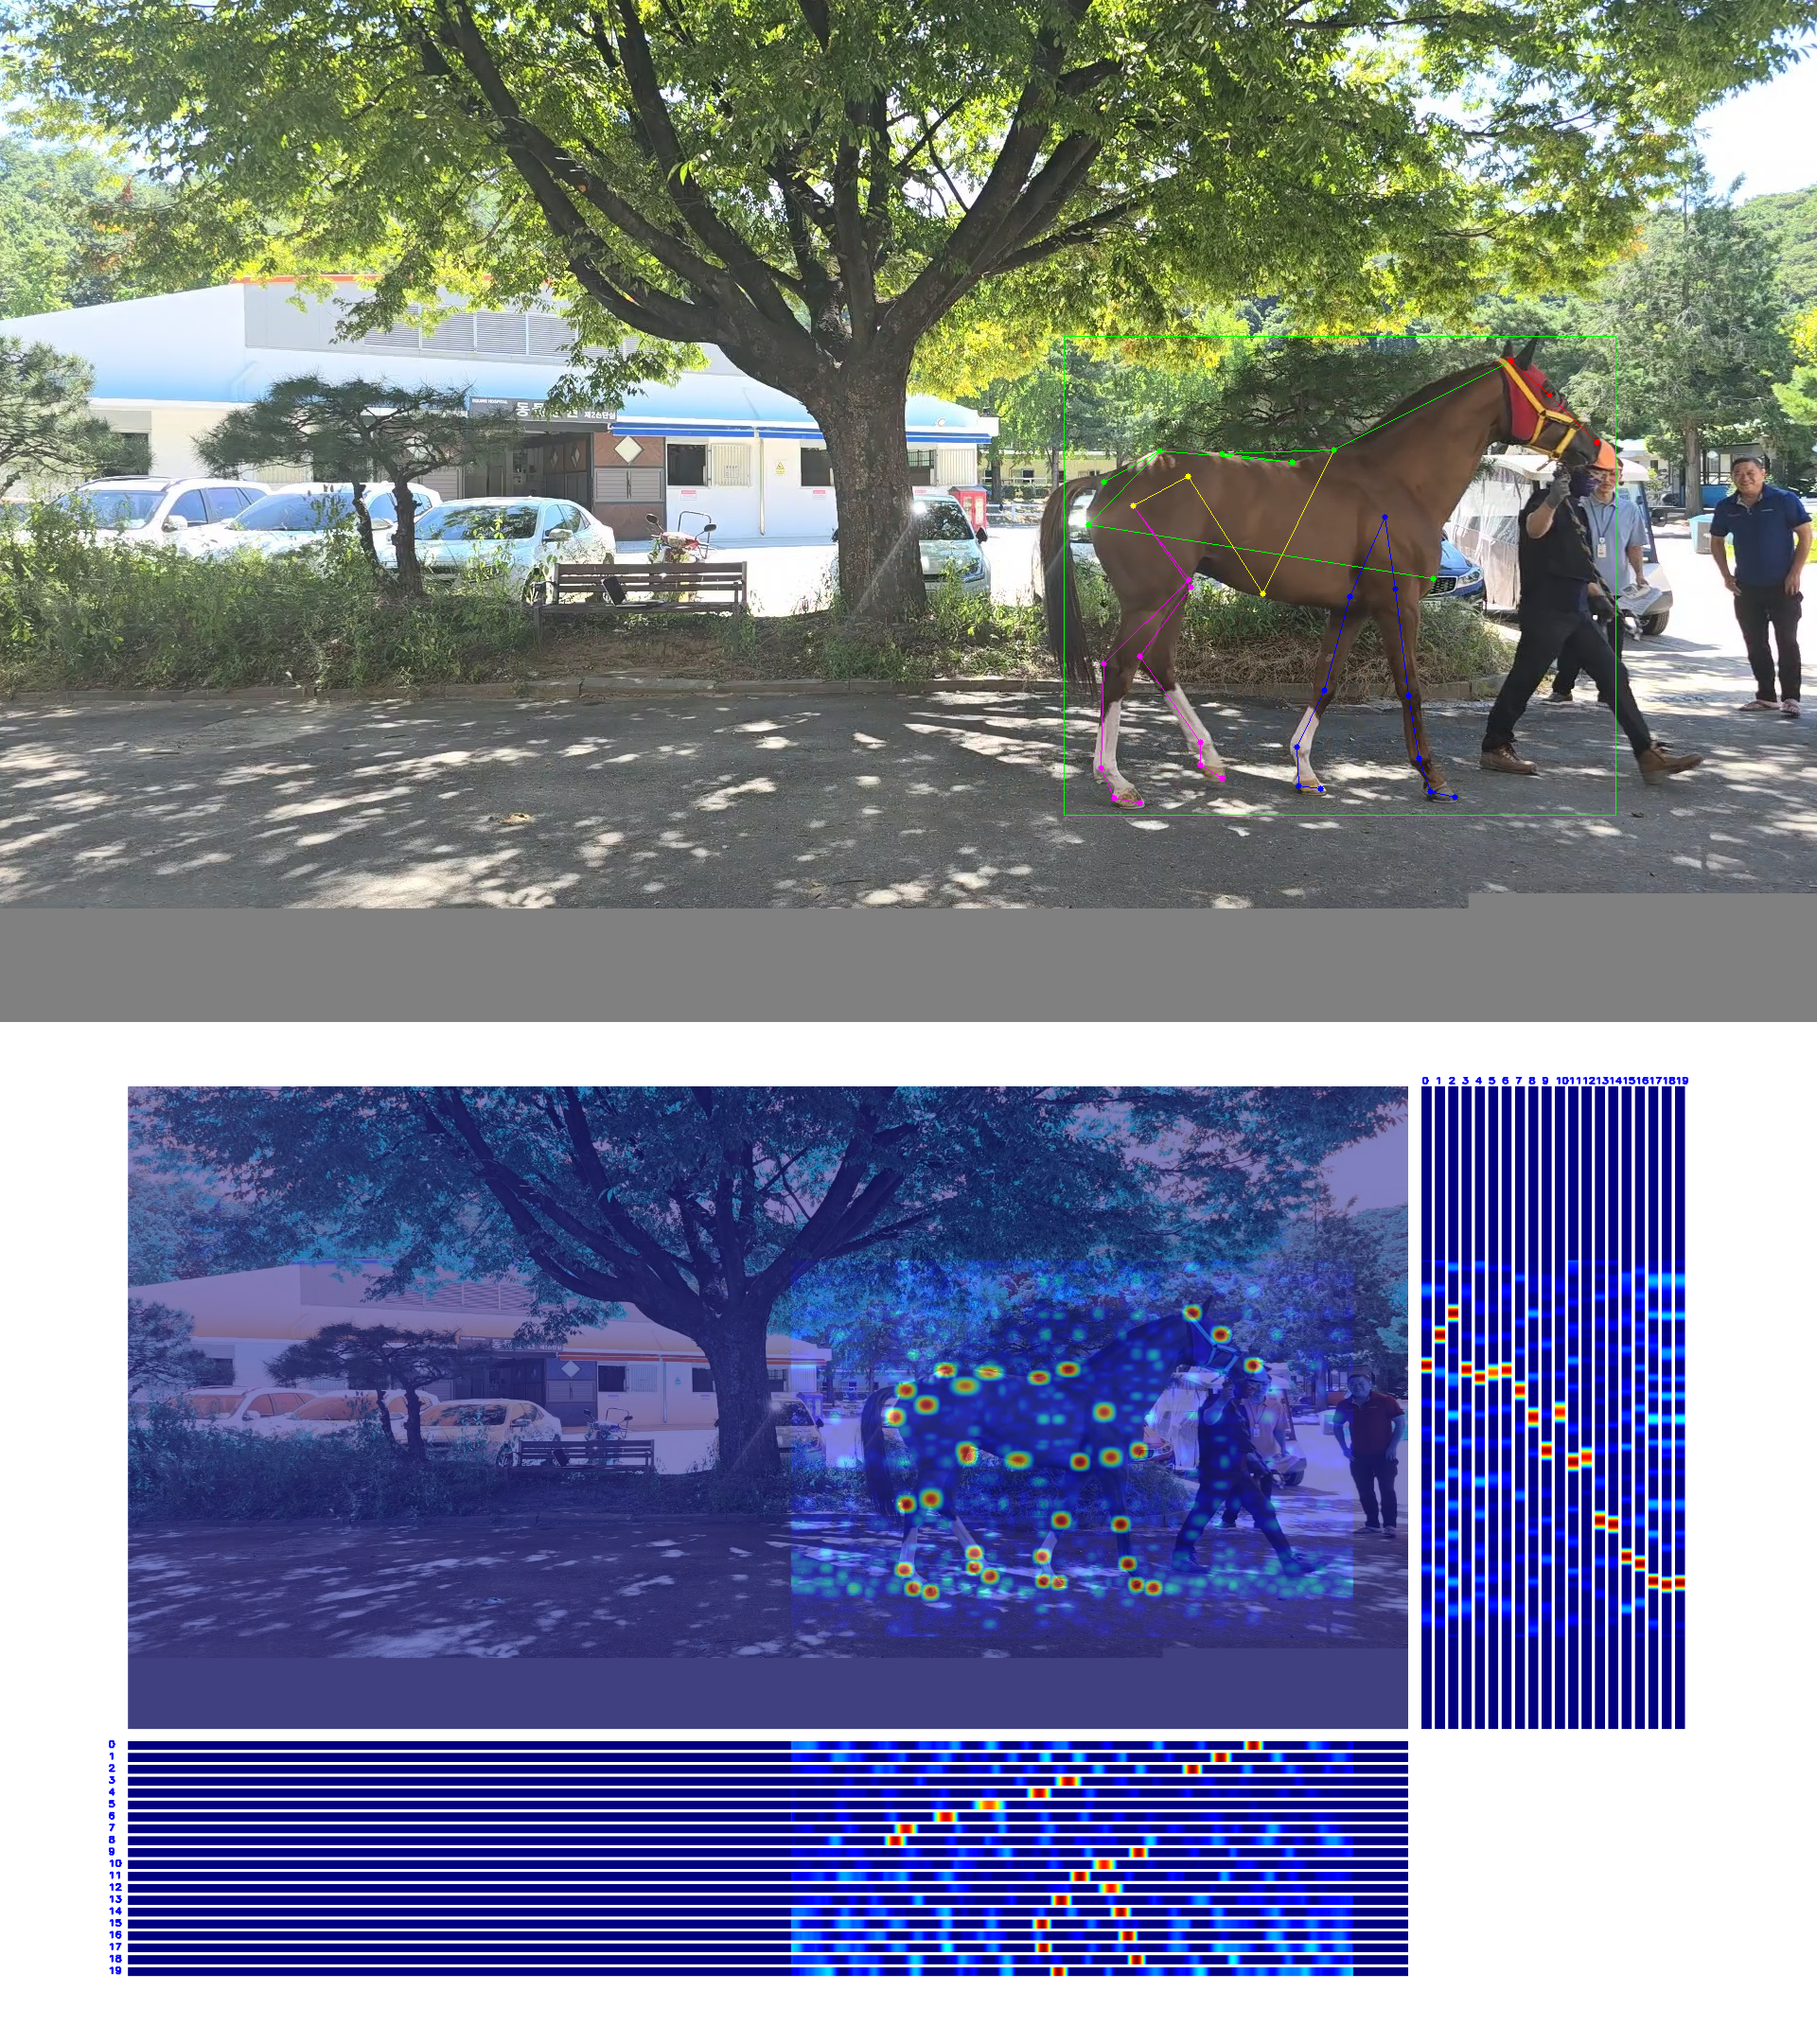

In [26]:
if local_runtime:
    from IPython.display import Image, display
    import tempfile
    import os.path as osp
    import cv2
    with tempfile.TemporaryDirectory() as tmpdir:
        file_name = osp.join(tmpdir, 'results.png')
        cv2.imwrite(file_name, vis_result[:,:,::-1])
        display(Image(file_name))
else:
    cv2_imshow(vis_result[:,:,::-1]) #RGB2BGR to fit cv2

In [18]:
print(vis_result.shape)

(2160, 1920, 3)
